In [17]:
import numpy as np
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

To solve the questions I firstly compute some relevant functions.

In [4]:
# create basic functions
def utility(c, rho):
    return c**(1 - rho)/(1 - rho)

def disutility(gamma, l):
    return gamma*l

def cons(w, h, b, l):
    return w*h*l + b*(1 - l)

def v2(l2, w, b, h2, rho, gamma):
    return utility(cons(w, h2, b, l2), rho) - disutility(gamma, l2)

def v1(l1, w, b, rho, gamma, h1, Delta, beta, v2_interp):
    
    # v2 if 0 extra human capital
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # v2 if Delta extra human capital
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # total value
    return utility(cons(w, h1, b, l1), rho) - disutility(gamma, l1) + beta*v2

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital).

Text(0.5, 1.0, 'labor supply in period 2')

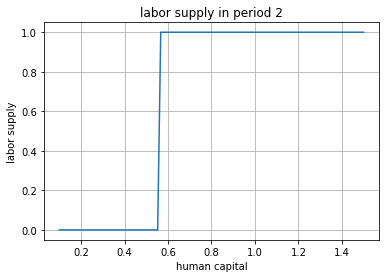

In [22]:
# Question 1: solve model in period 2
def solve_period_2(rho, w, b, h_vec, gamma, Delta):

    # a. grids
    v2_vec = np.empty(100)
    l2_vec = np.empty(100, dtype=int)

    # b. solve for each h in grid
    for i,h in enumerate(h_vec):
       
        # i. compare v2 for l2 = 0 and l2 = 1 and return the l2 that maximizes v2
        if (v2(0, w, b, h, rho, gamma) > v2(1, w, b, h, rho, gamma)) == True:
            l2_vec[i] = 0
        else:
            l2_vec[i] = 1
        
        # ii. append the v2 value from the optimized l2
        v2_vec[i] = v2(l2_vec[i], w, b, h, rho, gamma)
               
    return v2_vec, l2_vec

v2_vec, l2_vec = solve_period_2(rho, w, b, h_vec, gamma, Delta)

# illustrate period 2 solution
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec, l2_vec)

# set grids
ax.grid()
    
# v. set labels
ax.set_ylabel('labor supply')
ax.set_xlabel('human capital')

# set title
ax.set_title('labor supply in period 2')

Skriv noget tekst

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

Text(0.5, 1.0, 'labor supply in period 1')

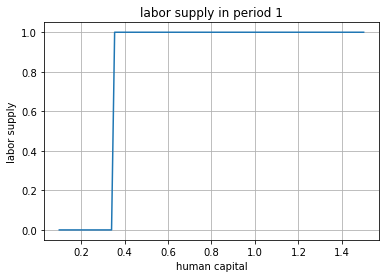

In [34]:
# question 2: Solve the model in period 1 
#interpolate
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)

def solve_period_1(w, b, rho, gamma, h_vec, Delta, beta, v2_interp):
    
    # a. grids
    v1_vec = np.empty(100)
    l1_vec = np.empty(100, dtype=int)
    
    # b. solve for each h in grid
    for i,h in enumerate(h_vec):
       
        # i. compare v1 for l1 = 0 and l1 = 1 and return the l1 that maximizes v1
        if (v1(0, w, b, rho, gamma, h, Delta, beta, v2_interp) > v1(1, w, b, rho, gamma, h, Delta, beta, v2_interp)) == True:
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        # ii. append the v1 value from the optimized l1
        v1_vec[i] = v1(l1_vec[i], w, b, rho, gamma, h, Delta, beta, v2_interp)
               
    return v1_vec, l1_vec

v1_vec, l1_vec = solve_period_1(w, b, rho, gamma, h_vec, Delta, beta, v2_interp)

# illustrate period 1 result
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(h_vec, l1_vec)

# set grids
ax.grid()
    
# v. set labels
ax.set_ylabel('labor supply')
ax.set_xlabel('human capital')

# set title
ax.set_title('labor supply in period 1')

Skriv noget tekst

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [4]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [5]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [6]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [7]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

**GAMMEL KODE**

In [52]:
# NOT SOLVED

# Question 1: solve model in period 2
def solve_period_2(rho, w, b, h_vec, gamma, Delta):

    # a. grids
    v2_vec = np.empty(100)
    l2_vec = np.empty(100, dtype=int)

    # b. solve for each m2 in grid
    for i,h in enumerate(h_vec):

        # i. objective
        obj = lambda l2: -v2(l2, w, b, h, rho, gamma)

        # ii. initial value 
        x0 = 1

        # iii. optimizer
        result = optimize.minimize_scalar(obj, x0, method='bounded',bounds=[0,1])

        # iv. save
        v2_vec[i] = -result.fun
        l2_vec[i] = result.x
        
    return v2_vec, l2_vec

v2_vec, l2_vec = solve_period_2(rho, w, b, h_vec, gamma, Delta)
print(v2_vec)

[-1.00000536 -1.0000052  -1.00000503 -1.00000486 -1.00000469 -1.00000452
 -1.00000435 -1.00000418 -1.00000402 -1.00000385 -1.00000368 -1.00000351
 -1.00000334 -1.00000317 -1.000003   -1.00000284 -1.00000267 -1.0000025
 -1.00000233 -1.00000216 -1.00000199 -1.00000182 -1.00000166 -1.00000149
 -1.00000132 -1.00000115 -1.00000098 -1.00000081 -1.00000064 -1.00000048
 -1.00000031 -1.00000014 -0.99940783 -0.98235296 -0.96086968 -0.94040767
 -0.9208958  -0.90226939 -0.88446951 -0.86744233 -0.85113861 -0.83551319
 -0.82052462 -0.80613473 -0.79230837 -0.77901305 -0.76621876 -0.75389771
 -0.74202412 -0.73057404 -0.71952521 -0.70885691 -0.69854981 -0.68858587
 -0.67894823 -0.66962112 -0.66058977 -0.65184034 -0.64335983 -0.63513602
 -0.62715744 -0.61941327 -0.61189334 -0.60458805 -0.59748833 -0.59058563
 -0.58387186 -0.57733937 -0.57098091 -0.56478962 -0.55875899 -0.55288286
 -0.54715535 -0.5415709  -0.53612422 -0.53081027 -0.52562425 -0.5205616
 -0.51561798 -0.51078923 -0.50607139 -0.50146069 -0.4